In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

##通用function
# 計算 total / 列百分比 / 欄百分比
def add_total_and_pct(cross_df):
    df = cross_df.copy()
    
    # 列總和
    df['row_total'] = df.sum(axis=1)
    
    # 欄總和
    col_total = df.sum(axis=0)
    df.loc['col_total'] = col_total
    
    # 列百分比
    df_row_pct = df.div(df['row_total'], axis=0) * 100
    df_row_pct = df_row_pct.round(1)
    
    # 欄百分比
    df_col_pct = df.div(df.loc['col_total'], axis=1) * 100
    df_col_pct = df_col_pct.round(1)
    
    # 合併三種資訊 (欄位加後綴)
    combined = pd.concat(
        [df.astype(int).add_suffix('_count'),
         df_row_pct.add_suffix('_row%'),
         df_col_pct.add_suffix('_col%')],
        axis=1
    )
    
    return combined

##read_csv
condition_occurrence_df = pd.read_csv("condition_occurrence.csv", encoding="utf-8")
observation_df = pd.read_csv("observation.csv", encoding="utf-8")
person_df = pd.read_csv("person.csv", encoding="utf-8")

##person
current_year = datetime.now().year
person_df["birth_datetime"] = pd.to_datetime(person_df["birth_datetime"], errors="coerce")
person_df["Current_Age"] = current_year - person_df["birth_datetime"].dt.year
bins = [-1, 17, 29, 39, 49, 59, 69, 79, 89, float("inf")]
labels = ["<18", "18-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "89+"]
person_df["Age_Group"] = pd.cut(person_df["Current_Age"], bins=bins, labels=labels)

##Crosstab
# AgeGender
AgeGender_cross = pd.crosstab(
    index = person_df['Age_Group'],
    columns = person_df['gender_source_value']
)

AgeGender_cross = add_total_and_pct(AgeGender_cross)
AgeGender_cross

# RaceGender
RaceGender_cross = pd.crosstab(
    index = person_df['race_source_value'],
    columns = person_df['gender_source_value']
)

RaceGender_cross = add_total_and_pct(RaceGender_cross)
RaceGender_cross

# EthnicityGender
EthnicityGender_cross = pd.crosstab(
    index = person_df['ethnicity_source_value'],
    columns = person_df['gender_source_value']
)

EthnicityGender_cross = add_total_and_pct(EthnicityGender_cross)
EthnicityGender_cross

EthnicityGender_cross

gender_source_value,F_count,M_count,row_total_count,F_row%,M_row%,row_total_row%,F_col%,M_col%,row_total_col%
ethnicity_source_value,,,,,,,,,
非西班牙裔,1115,809,1924,58.0,42.0,100.0,100.0,100.0,100.0
col_total,1115,809,1924,58.0,42.0,100.0,100.0,100.0,100.0


,observation_source_concept_id,observation_source_value,proportion
0,0,2,20.23%
1,0,20,12.12%
2,0,E11.9,4.46%
3,0,40,4.37%
4,0,C34.11,3.65%
...,...,...,...
390,46718995,3,20.59%
391,46718997,1,34.62%
392,46718997,3,30.77%
393,46718997,2,27.88%


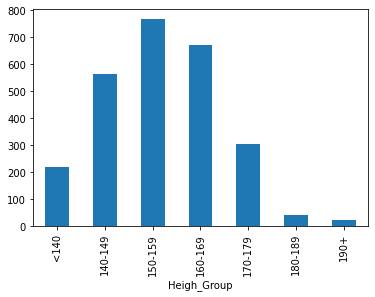

In [12]:
##observation

#join person
observation_join_df = pd.merge(observation_df, person_df, how='left', left_on='person_id', right_on='person_id')
observation_join_df = observation_join_df[observation_join_df['unit_source_value'] == "kg"]

# 體重分組切點 (kg)
bins = [0, 50, 60, 70, 80, 90, 100, 120, float("inf")]
labels = ["<50", "50-59", "60-69", "70-79", "80-89", "90-99", "100-119", "120+"]

# 建立新欄位
observation_join_df["Weight_Group"] = pd.cut(observation_join_df["value_as_number"], bins=bins, labels=labels)
observation_join_df["Weight_Group"].value_counts().sort_index().plot(kind="bar")

#join person
observation_join_df = pd.merge(observation_df, person_df, how='left', left_on='person_id', right_on='person_id')
observation_join_df = observation_join_df[observation_join_df['unit_source_value'] == "cm"]

# 身高分組切點(cm)
bins = [1, 140, 150, 160, 170, 180, 190, float("inf")]
labels = ["<140", "140-149", "150-159", "160-169", "170-179", "180-189", "190+"]

# 建立新欄位
observation_join_df["Heigh_Group"] = pd.cut(observation_join_df["value_as_number"], bins=bins, labels=labels)
observation_join_df["Heigh_Group"].value_counts().sort_index().plot(kind="bar")

#join person
observation_join_df = pd.merge(observation_df, person_df, how='left', left_on='person_id', right_on='person_id')
observation_join_df

##答案分布
# Observation_source
proportion_df = (
    observation_join_df
    .groupby('observation_source_concept_id')['observation_source_value']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
)
proportion_df['proportion'] = (proportion_df['proportion'] * 100).round(2).astype(str) + '%'
proportion_df

In [13]:
##condition_occurrence
#join person
condition_occurrence_join_df = pd.merge(condition_occurrence_df, person_df, how='left', left_on='person_id', right_on='person_id')

##Crosstab
# Condition_source(Gender)
Condition_Gender_cross = pd.crosstab(
    index = condition_occurrence_join_df['gender_source_value'],
    columns = condition_occurrence_join_df['condition_source_concept_id']
)
Condition_Gender_cross = add_total_and_pct(Condition_Gender_cross)
Condition_Gender_cross

# Condition_source(AgeGroup)
Condition_AgeGroup_cross = pd.crosstab(
    index = condition_occurrence_join_df['Age_Group'],
    columns = condition_occurrence_join_df['condition_source_concept_id']
)
Condition_AgeGroup_cross = add_total_and_pct(Condition_AgeGroup_cross)
Condition_AgeGroup_cross

# 診斷年
condition_occurrence_join_df['condition_start_date'] = pd.to_datetime(condition_occurrence_join_df['condition_start_date'], format='%Y/%m/%d', errors='coerce')
condition_occurrence_join_df['condition_start_year'] = condition_occurrence_join_df['condition_start_date'].dt.year
Condition_year_cross = pd.crosstab(
    index = condition_occurrence_join_df['condition_start_year'],
    columns = condition_occurrence_join_df['condition_source_concept_id']
)
Condition_year_cross

condition_source_concept_id,0,46552673,46718712,46718713,46718714,46718715,46718716,46718717,46718718
condition_start_year,,,,,,,,,
1900,0,1284,0,0,0,0,0,0,0
2015,76,0,2,1,9,3,0,36,19
2016,0,0,0,0,15,1,1,38,1
2017,16,0,2,4,5,10,9,58,13
2018,84,0,5,1,10,20,7,72,8
2019,14,0,3,3,4,9,12,62,7


## 組間比較 

In [14]:
## 兩種疾病人群比較年齡 (描述性統計 → 常態性檢定 → 選擇非參數方法 → Mann-Whitney U test → 中位數解讀 → 結論)
condition_occurrence_join_df = pd.merge(condition_occurrence_df, person_df, how='left', left_on='person_id', right_on='person_id')

# 過濾兩組資料
lung_cancer = condition_occurrence_join_df[condition_occurrence_join_df['condition_type_concept_id'] == 46718999]['Current_Age']
oral_cancer = condition_occurrence_join_df[condition_occurrence_join_df['condition_type_concept_id'] == 46718920]['Current_Age']

# 描述性統計
desc = pd.DataFrame({
    'Lung Cancer': lung_cancer.describe(),
    'Oral Cancer': oral_cancer.describe()
})

print(desc)

print('------------------------------------------------------------------------')
# Shapiro-Wilk test
print("Lung Cancer:", shapiro(lung_cancer))
print("Oral Cancer:", shapiro(oral_cancer))
print("\n肺癌 (Lung Cancer) p ≈ 0 → 明顯不符合常態分布\n口腔癌 (Oral Cancer) p ≈ 0.00012 → 也不符合常態分布\n所以不適合用 t-test，故用非參數檢定：Mann-Whitney U test，比較兩組中位數或分布差異。")

print('------------------------------------------------------------------------')
u_stat, p_value = mannwhitneyu(lung_cancer, oral_cancer, alternative='two-sided')
print("U-statistic:", u_stat)
print("p-value:", p_value)
print("\np-value 遠小於 0.05 → 兩組年齡分布顯著不同，因為是非參數檢定（Mann-Whitney U test），需要看中位數差異來理解方向：")

print('------------------------------------------------------------------------')
median_values = condition_occurrence_join_df.groupby('condition_type_concept_id')['Current_Age'].median()
print(median_values)
print("\n肺癌中位數 65 > 口腔癌中位數 59 → 肺癌患者年齡偏大\n與 Mann-Whitney U test 的 p-value ≈ 8×10⁻⁴⁰ 結果一致，表示兩組年齡分布差異顯著，\n故可以得出結論：肺癌患者年齡整體比口腔癌患者偏高。")

       Lung Cancer  Oral Cancer
count  1284.000000   640.000000
mean     72.021807    57.801563
std      22.029941    13.098388
min      35.000000    27.000000
25%      59.000000    48.000000
50%      65.000000    59.000000
75%      73.000000    67.000000
max     125.000000    95.000000
------------------------------------------------------------------------
Lung Cancer: ShapiroResult(statistic=0.6993495617702579, pvalue=5.874661414596727e-43)
Oral Cancer: ShapiroResult(statistic=0.989230782554231, pvalue=0.00012115766138937941)

肺癌 (Lung Cancer) p ≈ 0 → 明顯不符合常態分布
口腔癌 (Oral Cancer) p ≈ 0.00012 → 也不符合常態分布
所以不適合用 t-test，故用非參數檢定：Mann-Whitney U test，比較兩組中位數或分布差異。
------------------------------------------------------------------------
U-statistic: 562399.5
p-value: 8.011403585123872e-40

p-value 遠小於 0.05 → 兩組年齡分布顯著不同，因為是非參數檢定（Mann-Whitney U test），需要看中位數差異來理解方向：
------------------------------------------------------------------------
condition_type_concept_id
46718920    59.0
46718999    65

In [15]:
## 兩種疾病人群比較性別
condition_occurrence_join_df = pd.merge(condition_occurrence_df, person_df, how='left', left_on='person_id', right_on='person_id')

contingency_table = pd.crosstab(
    condition_occurrence_join_df['condition_type_concept_id'], 
    condition_occurrence_join_df['gender_source_value']
)
print(contingency_table)

print('------------------------------------------------------------------------')
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi2:", chi2, "p-value:", p)
print("p值小於 0.05，肺癌組和口腔癌組的性別分布有顯著差異")

print('------------------------------------------------------------------------')


gender_source_value          F    M
condition_type_concept_id          
46718920                   116  524
46718999                   999  285
------------------------------------------------------------------------
Chi2: 621.8139273778316 p-value: 3.014640143281923e-137
p值小於 0.05，肺癌組和口腔癌組的性別分布有顯著差異
------------------------------------------------------------------------


In [16]:
!pip install OMOP.zip

Processing d:\冠文筆電備份\d\洛嫺\ghd_omop2\omop.zip
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for OMOP: filename=OMOP-0.2-py3-none-any.whl size=4180 sha256=4df542d5b748aa63c82ea0a81c951cdaad23e9cde172c0ded32693fdebe24e2b
  Stored in directory: C:\Users\USER\AppData\Local\Temp\pip-ephem-wheel-cache-2s9fj18q\wheels\d4\60\37\12428ffb7fabcf25ac1fcd24e984faced26473799aafa72e3e
Successfully built OMOP
  Attempting uninstall: OMOP
    Found existing installation: OMOP 0.2
    Uninstalling OMOP-0.2:
      Successfully uninstalled OMOP-0.2


  DEPRECATION: Building 'OMOP' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'OMOP'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [19]:
from OMOP import analyze_demographics, analyze_observations, analyze_conditions, compare_conditions

results1 = analyze_demographics(person_df)
results2 = analyze_observations(observation_df, person_df)
results3 = analyze_conditions(condition_occurrence_df, person_df)
results4 = compare_conditions(condition_occurrence_df, person_df, cond1=46718999, cond2=46718920)
print(results1.keys())
print(results2.keys())
print(results3.keys())
print(results4.keys())

results1['AgeGender']

dict_keys(['AgeGender', 'RaceGender', 'EthnicityGender'])
dict_keys(['Weight_Distribution', 'Height_Distribution', 'Observation_Proportion'])
dict_keys(['Condition_Gender', 'Condition_AgeGroup', 'Condition_Year'])
dict_keys(['Descriptive', 'Shapiro', 'MannWhitneyU', 'Median', 'ChiSquare'])


gender_source_value,F_count,M_count,row_total_count,F_row%,M_row%,row_total_row%,F_col%,M_col%,row_total_col%
Age_Group,,,,,,,,,
18-29,3,5,8,37.5,62.5,100.0,0.3,0.6,0.4
30-39,12,44,56,21.4,78.6,100.0,1.1,5.4,2.9
40-49,31,98,129,24.0,76.0,100.0,2.8,12.1,6.7
50-59,290,195,485,59.8,40.2,100.0,26.0,24.1,25.2
60-69,406,270,676,60.1,39.9,100.0,36.4,33.4,35.1
70-79,207,158,365,56.7,43.3,100.0,18.6,19.5,19.0
80-89,12,19,31,38.7,61.3,100.0,1.1,2.3,1.6
89+,154,20,174,88.5,11.5,100.0,13.8,2.5,9.0
col_total,1115,809,1924,58.0,42.0,100.0,100.0,100.0,100.0
